# M31 2015 Luminous Red Nova, timescales

### Tassos Fragkos & Jeff J. Andrews

In this notebook we are calculating relevant timescales for different donor and accretor stars at various times throughout the donor's lifetime. 

In [1]:
# modules
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import matplotlib.patches as mpatches

%matplotlib inline

In [31]:
# constants in cgs
Gconst = 6.674e-8
Msun = 1.989e33
Rsun = 6.957e10
secday = 3600.0*24.0
secyear = secday * 365.25

### Load MESA data

In [3]:
data_dir = '../static_runs/'

# 15 Msun giant

# 100 Rsun
file_dir = data_dir + 'M31_2015_LNR_15M_100R_tau1.data'
M15_100R = np.genfromtxt(file_dir, skip_header=5, names=True)

# 250 Rsun
file_dir = data_dir + 'M31_2015_LNR_15M_250R_tau1.data'
M15_250R = np.genfromtxt(file_dir, skip_header=5, names=True)

# 500 Rsun
file_dir = data_dir + 'M31_2015_LNR_15M_500R_tau1.data'
M15_500R = np.genfromtxt(file_dir, skip_header=5, names=True)

# 700 Rsun
file_dir = data_dir + 'M31_2015_LNR_15M_700R_tau1.data'
M15_700R = np.genfromtxt(file_dir, skip_header=5, names=True)

In [9]:
def set_interpolations(star):
    star_m_encl = interp1d(star['radius']*Rsun, star['mass']*Msun)
    star_log10_rho = interp1d(star['radius']*Rsun, star['logRho'])
    star_pressure_scale_height = interp1d(star['radius']*Rsun, star['pressure_scale_height']*Rsun)
    star_csound = interp1d(star['radius']*Rsun, star['csound'])
    star_t_thermal_to_surf = interp1d(star['radius']*Rsun, 10**star['log_thermal_time_to_surface'])
    dM_dr = star["dm"]/star["dr"]
    star_dM_dr = interp1d(star['radius']*Rsun, dM_dr)

    return star_m_encl, star_log10_rho, star_pressure_scale_height, star_csound, star_t_thermal_to_surf, star_dM_dr

In [20]:
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2

### Keplerian velocity function

In [12]:
def get_keplerian_velocity(M_enclosed, M_companion, a_separation):
    """ Provides the keplerian velocity (circular orbit)
    
    Arguments
    ---------
    M_enclosed : float
        Enclosed mass of the companion, assumed to be a point (Msun)
    M_companion : float
        Companion mass (Msun)
    a_separation : float
        Orbital separation (Rsun)
        
    Returns
    -------
    v_orb : float
        circular orbital velocity (km/s)
    """
    
    v_squared = Gconst * (M_enclosed + M_companion) * Msun / (a_separation * Rsun)
    v_orb = np.sqrt(v_squared) / 1.0e5 # converted from cm/s to km/s
    
    return v_orb

### Gravitational potential

In [13]:
def get_E_grav(M_enclosed, M_companion, a_separation):
    """ Provides the gravitational potential energy
    
    Arguments
    ---------
    M_enclosed : float
        Enclosed mass of the companion, assumed to be a point (Msun)
    M_companion : float
        Companion mass (Msun)
    a_separation : float
        Orbital separation (Rsun)
        
    Returns
    -------
    E_grav : float
        gravitational potential energy (erg)
    """

    E_grav = -Gconst * (M_enclosed*Msun) * (M_companion*Msun) / (a_separation*Rsun)
    
    return E_grav

### Orbital period

In [14]:
def get_P_orb(M_enclosed, M_companion, a_separation):
    """ Provides the orbital period
    
    Arguments
    ---------
    M_enclosed : float
        Enclosed mass of the companion, assumed to be a point (Msun)
    M_companion : float
        Companion mass (Msun)
    a_separation : float
        Orbital separation (Rsun)
        
    Returns
    -------
    P_orb : float
        Orbital period (s)
    """

    vel = get_keplerian_velocity(M_enclosed, M_companion, a_separation) * 1.0e5 # velocity in cm/s
    circumference = 2.0 * np.pi * a_separation*Rsun
    
    P_orb = circumference / vel
    
    return P_orb

### Define the frictional drag force from MacLeod & Ramirez-Ruiz (2015)

In [16]:
def get_F_drag(mass_in, vel_in, rho, scale_height):
    """ Provides the drag force from an inspiraling object
    
    Arguments
    ---------
    mass_in : float
        Companion mass (Msun)
    vel_in : float
        Companion velocity - assumed to be the Keplerian orbital (km/s)
    rho : float
        Local density (g/cm^3)
    scale_height : float
        Local pressure scale height (cm)
        
    Returns
    -------
    F_drag : float
        Drag force on the inspiraling companion (erg/s)
    """
    
    # Convert units to cgs
    mass = mass_in * Msun # Msun to g
    vel = vel_in * 1.0e5 # km/s to cm/s
        
    # Accretion radius
    R_accretion = 2.0 * Gconst * mass / vel**2
    
    # ratio of accretion radius to scale height
    eta = R_accretion / scale_height

    # Hoyle-Littleton drag
    F_drag_HL = np.pi * R_accretion**2 * rho * vel**2
    
    # Factor to adjust Hoyle-Littleton drag to MacLeod & Ramirez-Ruiz (2015) simulations
    f_factor = 1.91791946 + -1.52814698*eta + 0.75992092*eta**2
        
    # Drag force
    F_drag = F_drag_HL * f_factor
    
    return F_drag

### Now, let's define derivatives for the inspiral over the static stellar profile

In [17]:
def get_dE_dr(E_in, r_in, M_companion, star_m_encl, star_dM_dr):
    """ Calculates the energy dissipation rate with respect to radius
    
    Arguments
    ---------
    E_in : float
        Total energy dissipated in star (erg)
    star_m_encl : interp1d object
        Enclosed mass interpolation object (Msun)
    star_dM_dr : interp1d object
        dM_dr interpolation object (g/cm)
    r_in : float
        The radius in question (cm)
    M_companion : float
        The companion mass to the star (Msun)
        
    Returns
    -------
    dE_dr : float
        The derivative of radius with respect to radius (erg/cm)    
    """
    
    # Calculate dE_dr
    m_encl = star_m_encl(r_in)
    dM_dr = star_dM_dr(r_in)
    dE_dr = -Gconst * dM_dr * (M_companion*Msun) / (2.0*r_in) + Gconst * (m_encl * (M_companion*Msun)) / (2.0*r_in**2)

    return dE_dr



    
def get_dE_dt(E_in, r_in, M_companion, star_m_encl, star_log10_rho, star_pressure_scale_height):
    """ Calculates the energy dissipation rate
    
    Arguments
    ---------
    E_in : float
        Total energy dissipated in star (erg)
    r_in : float
        The radius in question (cm)
    M_companion : float
        The companion mass to the star (Msun)
    star_m_encl : interp1d object
        Enclosed mass interpolation object (Msun)
    star_log10_rho : interp1d object
        log10 density interpolation object (g/cm^3)
    star_pressure_scale_height : interp1d object
        Pressure scale height interpolation object (cm)
        
    Returns
    -------
    dE_dt : float
        The derivative of radius with respect to time (erg/s)    
    """
    
    # Calculate dE_dt
    m_encl = star_m_encl(r_in)
    velocity = get_keplerian_velocity(m_encl/Msun, M_companion, r_in/Rsun)
    rho = 10**star_log10_rho(r_in)
    scale_height = star_pressure_scale_height(r_in)
    dE_dt = -get_F_drag(M_companion, velocity, rho, scale_height) * (velocity*1.0e5)

    return dE_dt


    

def get_dr_dt(r_in, t_in, M_companion, star_m_encl, star_log10_rho, star_pressure_scale_height, star_dM_dr):
    """ Calculates the inspiral time of the star
    
    Arguments
    ---------
    r_in : float
        The radius in question (cm)
    t_in : float
        Latent variable for derivative
    M_companion : float
        The companion mass to the star (Msun)
    star_m_encl : interp1d object
        Enclosed mass interpolation object (Msun)
    star_log10_rho : interp1d object
        log10 density interpolation object (g/cm^3)
    star_pressure_scale_height : interp1d object
        Pressure scale height interpolation object (cm)
    star_dM_dr : interp1d object
        dM_dr interpolation object (g/cm)
        
    Returns
    -------
    dr_dt : float
        The derivative of radius with respect to time (cm/s)
    """
    
    # Calculate dE_dt
    m_encl = star_m_encl(r_in)
    velocity = get_keplerian_velocity(m_encl/Msun, M_companion, r_in/Rsun)
    rho = 10**star_log10_rho(r_in)
    scale_height = star_pressure_scale_height(r_in)
    dE_dt = -get_F_drag(M_companion, velocity, rho, scale_height) * (velocity*1.0e5)
    
    # Calculate dE_dr
    dM_dr = star_dM_dr(r_in)
    dE_dr = -Gconst * dM_dr * (M_companion*Msun) / (2.0*r_in) + Gconst * (m_encl * (M_companion*Msun)) / (2.0*r_in**2)
    
    # dr_dt
    dr_dt = dE_dt / dE_dr
        
    return dr_dt
    

In [43]:
def get_dE_dm(r_in, M_companion, star_m_encl, star_dM_dr):
    """ Calculates the energy deposited per mass
    
    Arguments
    ---------
    r_in : float
        The radius in question (cm)
    M_companion : float
        The companion mass to the star (Msun)
    star_m_encl : interp1d object
        Enclosed mass interpolation object (Msun)
    star_dM_dr : interp1d object
        dM_dr interpolation object (g/cm)
        
    Returns
    -------
    dE_dm : float
        The derivative of energy with respect to mass (eta)
    """
    m_encl = star_m_encl(r_in)
    dM_dr = star_dM_dr(r_in)

    dE_dr = -Gconst * dM_dr * (M_companion*Msun) / (2.0*r_in) + Gconst * (m_encl * (M_companion*Msun)) / (2.0*r_in**2)

    return dE_dr / dM_dr


In [94]:
star = M15_700R

star_m_encl, star_log10_rho, star_pressure_scale_height, star_csound, \
                             star_t_thermal_to_surf, star_dM_dr = set_interpolations(star)


# Determine the mass and radius at which the companion merges based on the Hill radius
r_hill = star['radius'] * (M_companion*Msun / (3.0 * star_m_encl(star['radius']*Rsun)))**(1./3.)
R_companion = (M_companion)**0.8
merger_idx = np.argmin(np.abs(R_companion - r_hill))
merger_mass = star['mass'][merger_idx]
merger_radius = star['radius'][merger_idx]

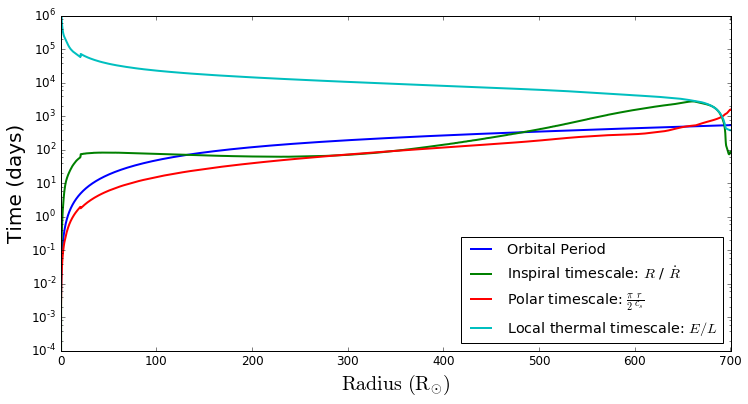

In [96]:
plt.figure(figsize=(12,6))

r_test = star["radius"]*Rsun
time = 0.0

M_companion = 0.5


def get_delta_t_therm(M_enclosed, M_companion, a_separation):

    vel = get_keplerian_velocity(M_enclosed, M_companion, a_separation) * 1.0e5 # velocity in cm/s
    R_accretion = 2.0 * Gconst * M_companion*Msun / vel**2

    t_thermal_low = star_t_thermal_to_surf(a_separation*Rsun)
    max_rad_array = star['radius'][0]*Rsun * np.ones(len(a_separation))
    t_thermal_high = star_t_thermal_to_surf(np.amin(np.vstack([a_separation*Rsun + R_accretion, max_rad_array]), axis=0))

    return t_thermal_high - t_thermal_low





dr_dt = get_dr_dt(r_test, time, M_companion, star_m_encl, star_log10_rho, star_pressure_scale_height, star_dM_dr)
P_orb = get_P_orb(star_m_encl(r_test)/Msun, M_companion, r_test/Rsun) / secday
plt.plot(r_test/Rsun, P_orb, label='Orbital Period')
plt.plot(r_test/Rsun, np.abs(r_test / dr_dt / secday), label=r'Inspiral timescale: $R$ / $\dot{R}$')



plt.plot(r_test/Rsun, np.pi/2. * r_test/star_csound(r_test) / secday, label=r'Polar timescale: $\frac{\pi}{2} \frac{r}{c_s}$')

# Energy radiation timescale
plt.plot(star['radius'], star['energy']/star['luminosity'] / secday, color='c', label=r'Local thermal timescale: $E/L$')


plt.xlabel(r'${\rm Radius}\ ({\rm R}_{\odot})$', size=20)
plt.ylabel('Time (days)', size=20)

plt.xlim(0.1, star['radius'][0])
plt.ylim(0.0001, 1000000)
#plt.xscale('log')
plt.yscale('log')

plt.legend(loc=4)

plt.show()

### Now, let's look at some energies

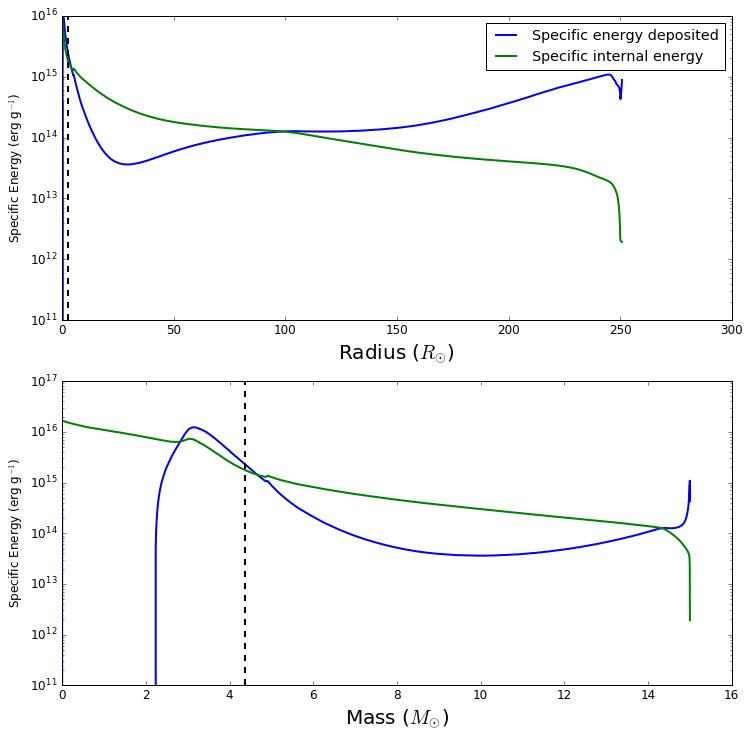

In [93]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))


dE_dm = get_dE_dm(star['radius']*Rsun, M_companion, star_m_encl, star_dM_dr)

ax[0].plot(star['radius'], dE_dm, label='Specific energy deposited')
ax[0].plot(star['radius'], star['energy'], label='Specific internal energy')
ax[0].legend()
ax[0].set_ylim(1.0e11, 1.0e16)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'Radius ($R_{\odot}$)', size=20)
ax[0].set_ylabel(r'Specific Energy (erg g$^{-1}$)')
ax[0].axvline(merger_radius, color='k', linestyle='dashed')


ax[1].plot(star['mass'], dE_dm, label='Specific energy deposited')
ax[1].plot(star['mass'], star['energy'], label='Specific internal energy')
ax[1].set_ylim(1.0e11, 1.0e17)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'Mass ($M_{\odot}$)', size=20)
ax[1].set_ylabel(r'Specific Energy (erg g$^{-1}$)')
ax[1].axvline(merger_mass, color='k', linestyle='dashed')


plt.show()